In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
%matplotlib inline

In [2]:
# Checking if GPU enabled
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:print("Processing will happen on  GPU")
else:print("Processing will happen on  CPU")

Processing will happen on  GPU


In [3]:
# Creating Transform Object
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                               transforms.RandomRotation(10),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
# Downloading the Data
train_data = datasets.CIFAR10(root='../../../temp_data/', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='../../../temp_data/', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Definig Network Related Constants
BATCH_SIZE = 20
VALIDATION_SIZE =0.20
NUM_EPOCHS = 10

In [6]:
#splitting data into train & Val set
np.random.seed(10)
total_sample = len(train_data)
indices = list(range(total_sample))
np.random.shuffle(indices)
val_indices = int(VALIDATION_SIZE * total_sample)
train_idx , val_idx = indices[val_indices:], indices[:val_indices]

In [7]:
# Initializing samplers
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [8]:
#loading samples
train_set = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)
val_set = DataLoader(train_data, sampler=val_sampler, batch_size=BATCH_SIZE)
test_set = DataLoader(test_data, batch_size=BATCH_SIZE)

In [9]:
print(f"train_set shape : {len(train_set)}\nval_set shape : {len(val_set)}\ntest_set shape : {len(test_set)}")

train_set shape : 2000
val_set shape : 500
test_set shape : 500


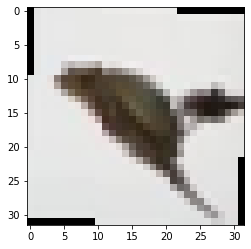

In [10]:
#analyze the data
images, labels = next(iter(train_set))
images = images.numpy()
plt.imshow(np.transpose((images[0]/2 + 0.5)))

In [11]:
#Definig the network architecture

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #defining convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)#as we are going with square kernels
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*4*4, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64*4*4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        out = self.fc2(x)
        return out

network  = Net()
print(network)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [12]:
#moving operations to cuda
if train_on_gpu:
    network.cuda()

In [13]:
#specify the loss of the system
criterian = nn.CrossEntropyLoss()
#defining the optimizer
optimizer = optim.SGD(params=network.parameters(),lr=0.01)

In [14]:
valid_loss_min = np.Inf
for epoch in range(1, NUM_EPOCHS+1):
    training_loss = 0
    validation_loss = 0
    ##################
    #TRAINING MODE####
    ##################
    network.train()#Model layers will know that training is going on
    
    for images, labels in train_set:
        
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        output = network.forward(images)
        loss = criterian(output, labels)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        
    #####################
    ##VALIDATION MODE####
    #####################
    network.eval()
    
    for images, labels in val_set:
        
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        output = network.forward(images)
        loss = criterian(output, labels)
        validation_loss += loss.item()
        
    #calculating average loss
    training_loss = training_loss / len(train_set.sampler)
    validation_loss = validation_loss / len(val_set.sampler)
    
    print(f"Epochs : {epoch}\ntraining_loss: {training_loss:.6f}\nvalidation_loss: {validation_loss:.6f}")
    
    #save model when balidation loss decreases
    if validation_loss <= valid_loss_min:
        print(f"validation loss decreased from {valid_loss_min:.6f} to {validation_loss:.6f}now saving the model")
        torch.save(network.state_dict(),'../out/model_cifar10.pt')
        valid_loss_min = validation_loss    

Epochs : 1
training_loss: 0.107833
validation_loss: 0.093983
validation loss decreased from inf to 0.093983now saving the model
Epochs : 2
training_loss: 0.087179
validation_loss: 0.077561
validation loss decreased from 0.093983 to 0.077561now saving the model
Epochs : 3
training_loss: 0.076477
validation_loss: 0.070394
validation loss decreased from 0.077561 to 0.070394now saving the model
Epochs : 4
training_loss: 0.070846
validation_loss: 0.067464
validation loss decreased from 0.070394 to 0.067464now saving the model
Epochs : 5
training_loss: 0.066867
validation_loss: 0.063155
validation loss decreased from 0.067464 to 0.063155now saving the model
Epochs : 6
training_loss: 0.063507
validation_loss: 0.058341
validation loss decreased from 0.063155 to 0.058341now saving the model
Epochs : 7
training_loss: 0.060272
validation_loss: 0.056338
validation loss decreased from 0.058341 to 0.056338now saving the model
Epochs : 8
training_loss: 0.057859
validation_loss: 0.055039
validation lo

In [15]:
#load the model with lowest validation loss
network.load_state_dict(torch.load('../out/model_cifar10.pt'))

<All keys matched successfully>

In [16]:
#Testing the model against the test set
test_loss = 0
class_correct = list(0 for i in range(10))
class_total = list(0 for i in range(10))
network.eval()
for images, labels in test_set:
    if train_on_gpu:
        images, labels  = images.cuda(), labels.cuda()
    output = network.forward(images)
    loss = criterian(output, labels)
    test_loss += loss.item()
    #convert output probabilities to predicted cloud
    _, pred = torch.max(output, 1)
    #compare with true labels
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    for i in range(BATCH_SIZE):
        label = labels[i].item()
        class_correct[label] += correct[i].item()
        class_total[label] +=1
#average test loss
average_test_loss = test_loss/len(test_set.sampler)
print(f"average test loss : {average_test_loss}")

average test loss : 0.0499835362225771
